In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import time
from pandas import scatter_matrix
import matplotlib.pyplot as plt

import sklearn
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# full dataset for time independent prediction
df = pd.read_csv("qfactors_terrorism.csv")
df = df.drop(['eventid'], axis=1)
df = df.where((pd.notnull(df)), None)

# training set of observations from 1990-2014
df_train = df[((df['iyear']) < 2015)]
# test set of observations from 2015-2016
df_test = df[(df['iyear']) >= 2015]

df.head(3)

,gname,iyear,extended,country,country_txt,city,latitude,longitude,success,suicide,...,education,freedom,gni_per_cap,gov_conf,immigrants,life_exp,pop_den,pov_gap,refugees,primary_enroll
0,Alejo Calatayu,1990,0,26,Bolivia,Cochabamba,-17.382789,-66.166439,1,0,...,0.527850,2.0,2280.0,0.0,73758.0,55.107293,6.329035,0.670000,200.0,100.132179
1,Nicaraguan Resistance,1990,0,145,Nicaragua,Puerto Cabezas,14.233737,-83.538859,1,0,...,0.343111,3.0,1900.0,0.0,41421.0,64.135000,34.440460,0.000000,16000.0,87.443626
2,Revolutionary Armed Forces of Colombia (FARC),1990,0,45,Colombia,Unknown,5.026003,-74.030012,1,0,...,0.438778,3.0,4620.0,92.0,104277.0,68.297195,30.889198,4.939868,460.0,101.686012


In [3]:
# features to keep and drop for prediction
features = ['iyear', 'extended', 'success', 'suicide', 'attacktype1', 'individual', 'weaptype1', 'weapsubtype1', 'nkill']

# extract test sets
target = ['gname']
Y_full = df[target]
Y_train = df_train[target]
Y_test = df_test[target]

# extract training sets
X_full = df[features]
X_train = df_train[features]
X_test = df_test[features]

#corr_matrix = df[['country', 'iyear', 'freedom', 'life_exp', 'pov_gap', 'primary_enroll']]
#corr_matrix.corr()

In [4]:
# PCA (principal component analysis) for dimensionality reduction
pca = PCA(n_components=len(features))
pca.fit_transform(X_full)

print (pca.explained_variance_ratio_.cumsum())

[ 0.62446619  0.82150583  0.98854562  0.99675763  0.99952499  0.99973009
  0.99986945  0.9999898   1.        ]


In [5]:
# refit training sets after PCA
pca = PCA(n_components=4)
pca_df_features = pca.fit_transform(X_full)
pca_train_features = pca.fit_transform(X_train)
pca_test_features = pca.fit_transform(X_test)

In [6]:
# 80/20 training/validation split for full dataset
seed = 2018
validation_size = 0.20
X_full_train, X_validation, Y_full_train, Y_validation = train_test_split(pca_df_features, Y_full, test_size=validation_size, random_state=seed)

In [7]:
models = []

models.append(('GNB', GaussianNB()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5, metric='cityblock')))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('SVM', SVC(probability=True)))

In [8]:
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed) #ensure same seed so models are directly comparable
    cv_results = model_selection.cross_val_score(model, X_full_train, Y_full_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f%% (%f) - %s seconds" % (name, cv_results.mean(), cv_results.std(), round((time.time() - start_time),3))
    print(msg)

GNB: 0.063961% (0.004097) - 43.582 seconds
LDA: 0.146788% (0.005376) - 57.786 seconds
KNN: 0.210874% (0.007861) - 4.586 seconds
CART: 0.259568% (0.005834) - 25.881 seconds
RF: 0.262397% (0.006389) - 143.395 seconds


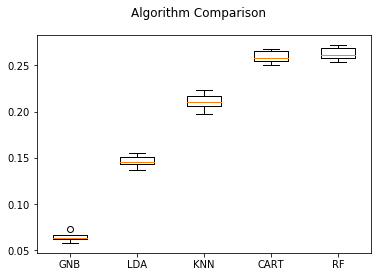

In [9]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [15]:
time_ind_model = RandomForestClassifier()
time_ind_model.fit(X_full_train, Y_full_train)
predictions = time_ind_model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.265141430948
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]]
                                                                                                    precision    recall  f1-score   support

                                                                                14 March Coalition       0.00      0.00      0.00         0
                                                                          14th of December Command       0.00      0.00      0.00         1
                                                                       20 December Movement (M-20)       0.00      0.00      0.00         5
                                                                                               28s       0.00      0.00      0.00         0
                                                                 A'chik Matgrik Elite Force (AMEF)       0.00      0.00      0.00         1
                

In [11]:
for name, model in models:
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed) #ensure same seed so models are directly comparable
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f%% (%f) - %s seconds" % (name, cv_results.mean(), cv_results.std(), round((time.time() - start_time),3))
    print(msg)

GNB: 0.002762% (0.001074) - 35.041 seconds
LDA: 0.088684% (0.037539) - 43.61 seconds
KNN: 0.131912% (0.047321) - 4.539 seconds
CART: 0.144651% (0.067934) - 7.162 seconds
RF: 0.146411% (0.069321) - 49.866 seconds


In [16]:
time_dep_model = RandomForestClassifier()
time_dep_model.fit(X_train, Y_train)
predictions = time_dep_model.predict(X_test)
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.217637380717
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
                                                                          precision    recall  f1-score   support

                                       A'chik Matgrik Elite Force (AMEF)       0.00      0.00      0.00         6
                                                       Abbala extremists       0.00      0.00      0.00         4
                                                    Abu Amarah Battalion       0.00      0.00      0.00         1
                                                  Abu Sayyaf Group (ASG)       0.08      0.04      0.05       158
              Aceh Singkil Islamic Care Youth Students Association (PPI)       0.00      0.00      0.00         3
                                                Achik Matgrik Army (AMA)       0.00      0.00      0.00         1
                                  Achik National Cooperati